Step $3$: pruning the wrong detected bars. The step $2$ returns the complete structure of the barcode: list of bars, with the starting pixel, width and height. However, some of these bars can be wrong. Aim of this step is to remove the wrong bars.

A "bar" is wrong if it is not an actual barcode bar, but it is another entity present in the ROI. In the datalogic images, this happens only two times: image $11$ (bar $0$ is wrong) and image $18$ (bar $34$ is wrong).

In [210]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils
import math
import matplotlib.patches as patches
import time

In [211]:
import importlib  

module = importlib.import_module('1) detect_roi')
detect_roi = module.detect_roi

module = importlib.import_module('2) rotate_image_boundingBox')
rotate_image_boundingBox = module.rotate_image_boundingBox

module = importlib.import_module('3) fix_horizontalBars_case')
fix_horizontalBars_case = module.fix_horizontalBars_case

module = importlib.import_module('4) compute_barcode_structure')
compute_barcode_structure = module.compute_barcode_structure

In [212]:
from os import listdir
from os.path import isfile, join
images_paths = [f for f in listdir('../images') if isfile(join('../images', f))]

In [213]:
image_path = f'../images/{images_paths[11]}'

(1024, 1280, 3)


Text(0.5, 1.0, 'Original image')

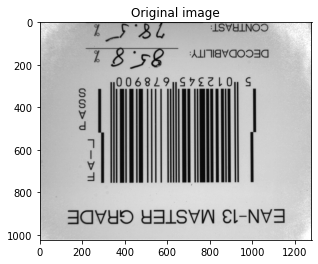

In [214]:
# load the image and convert it to grayscale
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(gray, 'gray')
plt.title('Original image')

array([[263., 250.],
       [951., 247.],
       [265., 772.],
       [953., 769.]], dtype=float32)

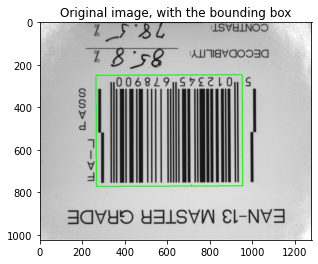

In [215]:
bb_points_sorted, bb_width, bb_height = detect_roi(image, visualize_bounding_box=True)
bb_points_sorted

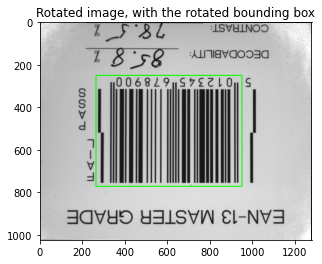

In [216]:
image_rot, bb_points_sorted_rot = rotate_image_boundingBox(image, bb_points_sorted, bb_width, bb_height, 
                                                           visualize_rot_image_bb=True)

In [217]:
image_rot, bb_points_sorted_rot, bb_width, bb_height = fix_horizontalBars_case(image_rot, bb_points_sorted_rot, bb_width, 
                                                                               bb_height, visualize_fixed_image_bb=True)

In [218]:
gray_rot = cv2.cvtColor(image_rot, cv2.COLOR_BGR2GRAY)
roi_image = gray_rot[int(bb_points_sorted_rot[0][1]):int(bb_points_sorted_rot[0][1]+bb_height), 
                             int(bb_points_sorted_rot[0][0]):int(bb_points_sorted_rot[0][0]+bb_width)]

Text(0.5, 1.0, 'ROI image')

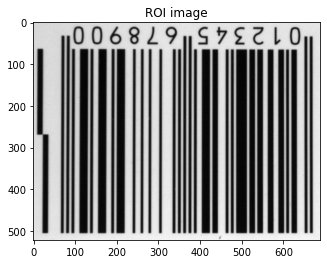

In [219]:
plt.figure()
plt.imshow(roi_image, 'gray')
plt.title('ROI image')

Time: 0.039879560470581055


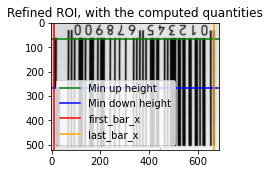

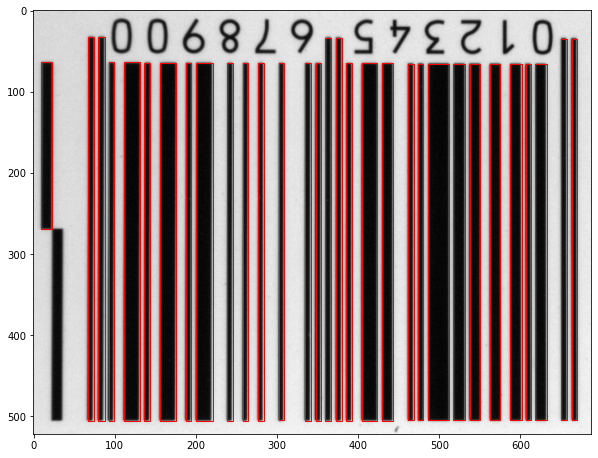

In [220]:
bars_start, bars_width, bars_halfHeightUp, bars_halfHeightDown = compute_barcode_structure(roi_image, bb_width, bb_height,
                                                                                           algorithm=1, verbose=True, 
                                                                                           visualize_refined_bb=True,
                                                                                           visualize_barcode_structure=True)

**As it can be seen, the thing on the left has been detected as a bar, even if it shouldn't be...**

## DETECTION OF A "WRONG" BAR
A "wrong" bar is detected as a bar which is an outlier. It is very different from the distribution of the other bars.

A "wrong" is an outlier w.r.t at least one of these two quantities: the height of the bar or the area of the bar.

In [221]:
def find_outliers(v):
    q1, q3 = tuple(np.quantile(v, [0.02,0.98]))
    IQR = q3-q1
    outliers_mask = np.logical_or(v>q3+IQR, v<q1-IQR)
    """print(outliers_mask)
    print(v[outliers_mask])"""
    if v[outliers_mask].size==0:
        return None
    return np.argmax([v[i]-q3-IQR if (outliers_mask[i] and v[i]-q3-IQR>0) else abs(v[i]-q1+IQR) if outliers_mask[i] else 0  for i in range(len(v))])

In [222]:
def find_wrong_bars(bars_start, bars_width, bars_halfHeightUp, bars_halfHeightDown):
    n_bars = len(bars_start)
    bars_height = np.array([bars_halfHeightUp[i]+bars_halfHeightDown[i]+1 for i in range(n_bars)])
    #print(bars_height)
    wrong_bars_height_index = find_outliers(bars_height)
    
    bars_area = np.array([bars_height[i]+bars_width[i] for i in range(n_bars)])
    wrong_bars_area_index = find_outliers(bars_area)
    
    if wrong_bars_area_index is None or wrong_bars_height_index is None or wrong_bars_area_index!=wrong_bars_height_index:
        return None
    
    return wrong_bars_area_index

In [224]:
wrong_bar_index = find_wrong_bars(bars_start, bars_width, bars_halfHeightUp, bars_halfHeightDown)
wrong_bar_index

0

## UPDATING THE BARCODE STRUCTURE

In [225]:
del bars_start[wrong_bar_index]
del bars_width[wrong_bar_index]
del bars_halfHeightUp[wrong_bar_index]
del bars_halfHeightDown[wrong_bar_index]

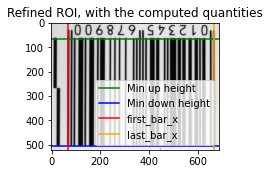

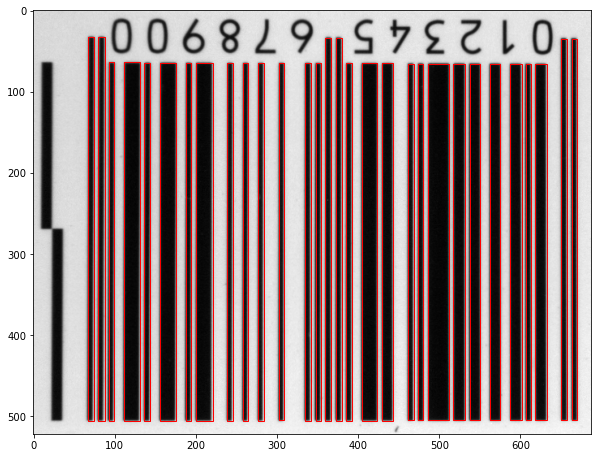

Text(0.5, 1.0, 'Exaustive barcode structure')

In [227]:
first_bar_x = min(bars_start)
last_bar_x = max([s+w for s,w in zip(bars_start,bars_width)])-1
X = min(bars_width)
min_half_height_up = min(bars_halfHeightUp)
min_half_height_down = min(bars_halfHeightDown)

half_height = int(bb_height/2)

plt.figure(figsize=(3, 3))
plt.imshow(roi_image, 'gray')
plt.axhline(half_height-min_half_height_up-1, c='green', label='Min up height')
plt.axhline(half_height+min_half_height_down-1, c='blue', label='Min down height')
plt.axvline(first_bar_x, c='red', label='first_bar_x')
plt.axvline(last_bar_x, c='orange', label='last_bar_x')
plt.title('Refined ROI, with the computed quantities')
plt.legend()

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(roi_image, 'gray')
n_bars = len(bars_start)
for b in range(n_bars):
    # Create a Rectangle patch
    rect = patches.Rectangle((bars_start[b]-0.5, half_height-bars_halfHeightUp[b]-1-0.5), bars_width[b], 
                             bars_halfHeightUp[b]+bars_halfHeightDown[b]+1, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()
ax.set_title('Exaustive barcode structure')

## TESTING

In [205]:
for b in [i for i in range(52) if i!=21]:
    image_path = f'../images/{images_paths[b]}'
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bb_points_sorted, bb_width, bb_height = detect_roi(image, visualize_bounding_box=False)
    image_rot, bb_points_sorted_rot = rotate_image_boundingBox(image, bb_points_sorted, bb_width, bb_height, 
                                                           visualize_rot_image_bb=False)
    image_rot, bb_points_sorted_rot, bb_width, bb_height = fix_horizontalBars_case(image_rot, bb_points_sorted_rot, bb_width, 
                                                                               bb_height, visualize_fixed_image_bb=False)
    gray_rot = cv2.cvtColor(image_rot, cv2.COLOR_BGR2GRAY)
    roi_image = gray_rot[int(bb_points_sorted_rot[0][1]):int(bb_points_sorted_rot[0][1]+bb_height), 
                                 int(bb_points_sorted_rot[0][0]):int(bb_points_sorted_rot[0][0]+bb_width)]
    
    bars_start, bars_width, bars_halfHeightUp, bars_halfHeightDown = compute_barcode_structure(roi_image, bb_width, bb_height,
                                                                                           algorithm=1, verbose=False, 
                                                                                           visualize_refined_bb=False,
                                                                                           visualize_barcode_structure=False)
    
    wrong_bar = find_wrong_bars(bars_start, bars_width, bars_halfHeightUp, bars_halfHeightDown)
    
    print(b, wrong_bar)

0 None
1 None
2 None
3 None
4 None
5 None
6 None
7 None
8 None
9 None
10 None
11 0
12 None
13 None
14 None
15 None
16 None
17 None
18 34
19 None
20 None
22 None
23 None
24 None
25 None
26 None
27 None
28 None
29 None
30 None
31 None
32 None
33 None
34 None
35 None
36 None
37 None
38 None
39 None
40 None
41 None
42 None
43 None
44 None
45 None
46 None
47 None
48 None
49 None
50 None
51 None


**Correct!**

In [209]:
for image_path in ['../other images/1.png','../other images/5.jpg','../other images/7.jpg','../other images/8.png']:
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bb_points_sorted, bb_width, bb_height = detect_roi(image, visualize_bounding_box=False)
    image_rot, bb_points_sorted_rot = rotate_image_boundingBox(image, bb_points_sorted, bb_width, bb_height, 
                                                           visualize_rot_image_bb=False)
    image_rot, bb_points_sorted_rot, bb_width, bb_height = fix_horizontalBars_case(image_rot, bb_points_sorted_rot, bb_width, 
                                                                               bb_height, visualize_fixed_image_bb=False)
    gray_rot = cv2.cvtColor(image_rot, cv2.COLOR_BGR2GRAY)
    roi_image = gray_rot[int(bb_points_sorted_rot[0][1]):int(bb_points_sorted_rot[0][1]+bb_height), 
                                 int(bb_points_sorted_rot[0][0]):int(bb_points_sorted_rot[0][0]+bb_width)]
    
    bars_start, bars_width, bars_halfHeightUp, bars_halfHeightDown = compute_barcode_structure(roi_image, bb_width, bb_height,
                                                                                           algorithm=1, verbose=False, 
                                                                                           visualize_refined_bb=False,
                                                                                           visualize_barcode_structure=False)
    
    wrong_bar = find_wrong_bars(bars_start, bars_width, bars_halfHeightUp, bars_halfHeightDown)
    
    print(image_path, wrong_bar)

../other images/1.png None
../other images/5.jpg None
../other images/7.jpg None
../other images/8.png None
